In [1]:
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np
import math

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [4]:
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [5]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

In [6]:
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [7]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6625],
         [-1.6810]]),
 tensor([[ 1.0000e+00, -6.6247e-01,  2.1943e-01, -4.8456e-02,  8.0252e-03,
          -1.0633e-03,  1.1740e-04, -1.1111e-05,  9.2006e-07, -6.7723e-08,
           4.4865e-09, -2.7020e-10,  1.4916e-11, -7.6013e-13,  3.5969e-14,
          -1.5886e-15,  6.5773e-17, -2.5631e-18,  9.4332e-20, -3.2891e-21],
         [ 1.0000e+00, -1.6810e+00,  1.4129e+00, -7.9169e-01,  3.3271e-01,
          -1.1186e-01,  3.1339e-02, -7.5258e-03,  1.5814e-03, -2.9536e-04,
           4.9651e-05, -7.5875e-06,  1.0629e-06, -1.3744e-07,  1.6503e-08,
          -1.8494e-09,  1.9430e-10, -1.9213e-11,  1.7943e-12, -1.5875e-13]]),
 tensor([ 3.0960, -6.3051]))

In [8]:
def evaluate_loss(net, data_iter, loss):   #@save
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3,  1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.004829   1.2493875 -3.4046655  5.490236 ]]


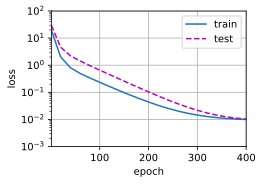

In [11]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.3131328 3.400239 ]]


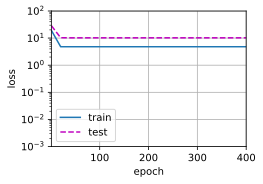

In [13]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.000693    1.2415836  -3.3557978   5.3247066  -0.2761691   1.1580322
   0.14768532  0.08264672 -0.20406713 -0.04390511 -0.1370018   0.03629916
  -0.14610481 -0.19433017  0.03601929  0.17711079  0.17883933  0.15318954
  -0.03366502 -0.0778688 ]]


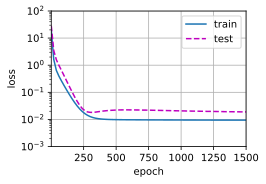

In [14]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], 1500)